In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
#Read NO-NO2-NOx Series
dataFrame = pd.read_excel("../data/DataAirTrain.xlsx",index_col= 'time', sheet_name="RH-Temp")
dataFrame.head(5)

,RH,Temp
time,,
2019-04-14 07:00:00,98.55,25.55
2019-04-14 08:00:00,99.62,25.17
2019-04-14 09:00:00,97.46,25.86
2019-04-14 10:00:00,88.45,27.67
2019-04-14 11:00:00,77.99,29.14


In [3]:
dataFrame = dataFrame.interpolate(method='linear')

In [4]:
#Fix gap in time index
dataFrame = dataFrame.resample('H').interpolate(method='linear')

In [5]:
# dataFrame[['RH']].plot(figsize= (20,4))
# dataFrame[['Temp']].plot(figsize= (20,4))

In [6]:
from statsmodels.tsa.stattools import adfuller
def stationary(var, desc):
    print(
        f"'{desc}' is stationary: "
        f"{adfuller(var)[0] < adfuller(var)[4]['1%']}.")
stationary(dataFrame[['RH']], 'RH')
stationary(dataFrame[['Temp']], 'Temp')

'RH' is stationary: True.
'Temp' is stationary: True.


In [7]:
trainSet = dataFrame[: -48]
testSet = dataFrame[-48: ]
dataFrameCopy = dataFrame
dataFrame = trainSet

In [8]:
from statsmodels.tsa.api import VAR
model = VAR(dataFrame)

In [9]:
sorted_order = model.select_order(60)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        6.307       6.311       548.7       6.309
1        3.913       3.924       50.06       3.917
2        3.434       3.452       31.00       3.440
3        3.412       3.438       30.32       3.421
4        3.374      3.406*       29.18       3.385
5        3.374       3.414       29.20       3.388
6        3.368       3.415       29.02       3.385
7        3.366       3.421       28.96       3.385
8        3.366       3.429       28.98       3.389
9        3.367       3.436       28.99       3.392
10       3.367       3.444       29.00       3.395
11       3.368       3.452       29.03       3.398
12       3.368       3.459       29.01       3.400
13       3.363       3.461       28.86       3.398
14       3.357       3.463       28.69       3.394
15       3.355       3.468       28.65       3.395
16       3.344       3.464     

In [10]:
lag = sorted_order.aic
results = model.fit(lag)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 07, Mar, 2023
Time:                     00:47:42
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    3.46030
Nobs:                     3382.00    HQIC:                   3.33694
Log likelihood:          -15018.4    FPE:                    26.2666
AIC:                      3.26829    Det(Omega_mle):         25.4623
--------------------------------------------------------------------
Results for equation RH
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            3.386909         1.367343            2.477           0.013
L1.RH            1.567878         0.017268           90.795           0.000
L1.Temp          0.004653         0.016638            0.280           0.780
L2.RH  

<AxesSubplot:title={'center':'Test Set'}, xlabel='time'>

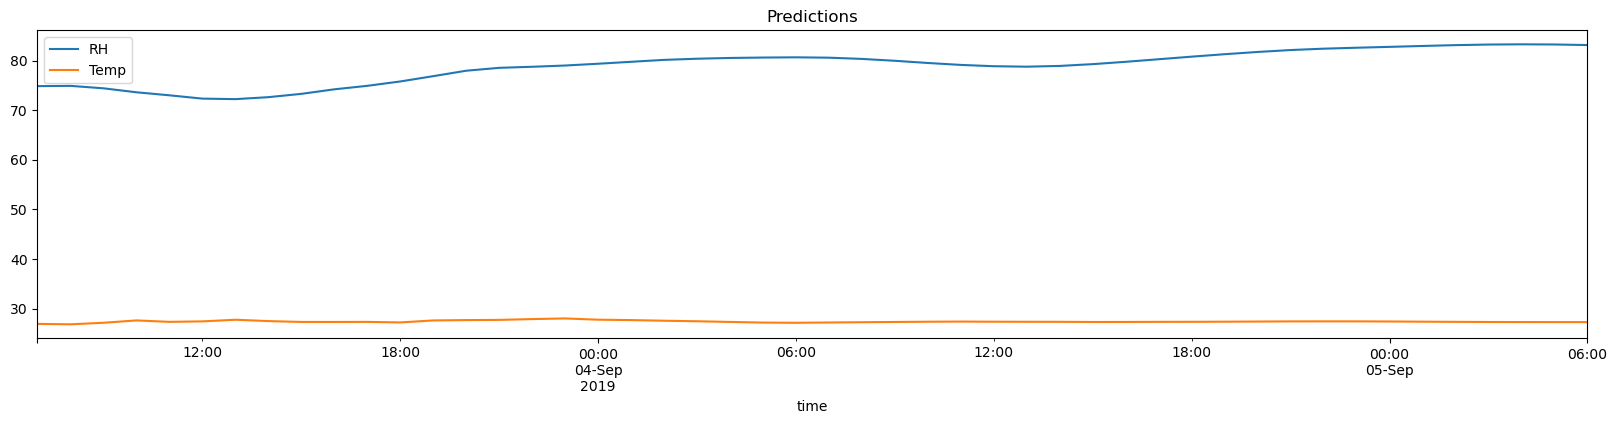

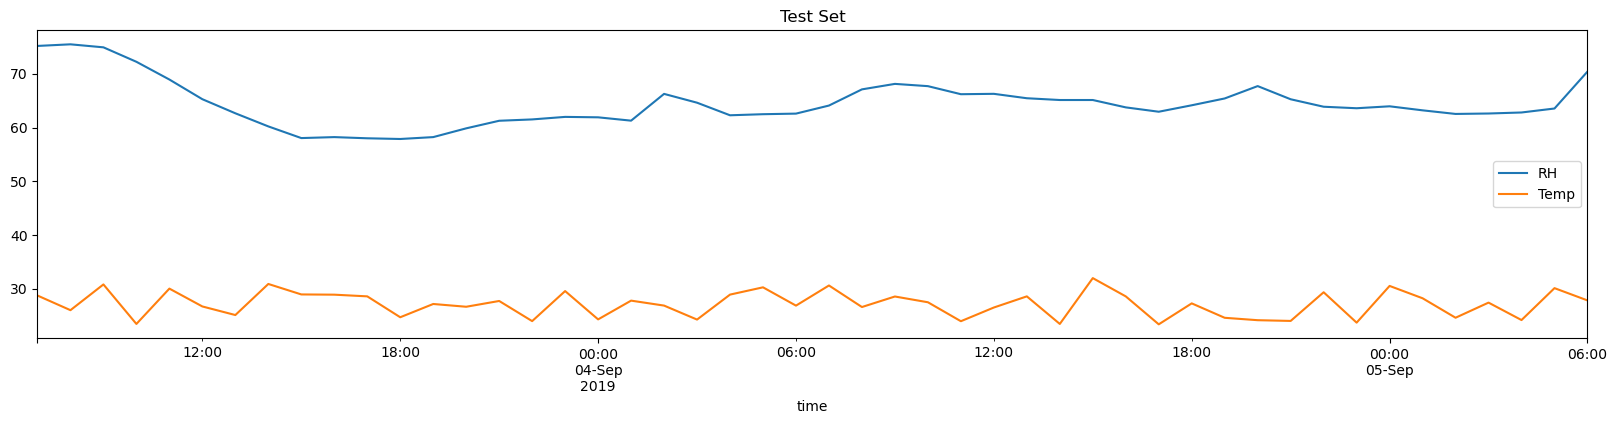

In [11]:
step = 48
dateTimeIndex = pd.date_range(dataFrame.index[-1] + pd.DateOffset(hours=1), periods=step, freq="H")
idx = pd.Index(dateTimeIndex, name='time')
predictions = results.forecast(dataFrame.values[-lag :], steps = step)
dataFramePredicted = pd.DataFrame(predictions, index=idx, columns=dataFrame.columns.values)
dataFramePredicted.plot(figsize=(20,4), title='Predictions')
testSet.plot(figsize=(20,4), title='Test Set')

In [12]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})
tmp = []
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,0], testSet.iloc[:,0]))
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,1], testSet.iloc[:,1]))
metric = pd.DataFrame(tmp,index=dataFramePredicted.columns.values)
print(metric)

          mape         me        mae       mpe       rmse      corr    minmax
RH    0.230775  14.499971  14.555562  0.230036  15.506674 -0.067046  0.182836
Temp  0.078176   0.246190   2.071854  0.017256   2.470332 -0.203939  0.072652


C:\Users\admin\AppData\Local\Temp\ipykernel_8396\557993791.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
C:\Users\admin\AppData\Local\Temp\ipykernel_8396\557993791.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\admin\AppData\Local\Temp\ipykernel_8396\557993791.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],
C:\Users\admin\AppData\Local\Temp\ipykernel_8396\557993791.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, Non